In [1]:
import numpy as np
import healpy as hp
from lsst.sims.featureScheduler.utils import Footprint, Footprints, standard_goals, step_line, step_slopes
import matplotlib.pylab as plt
%matplotlib inline
from lsst.sims.featureScheduler.modelObservatory import Model_observatory

In [2]:
mjd_start = 59853.5
sun_RA_start = 3.27717639


In [3]:
# Make a footprint object
fp = Footprint(mjd_start, sun_RA_start)

In [4]:
hp_footprints = standard_goals()
# Load the standard goals into the footprint object
for key in hp_footprints:
    fp.set_footprint(key, hp_footprints[key])

In [5]:
fp.footprints.view(dtype=fp.out_dtype).shape

(6, 2048)

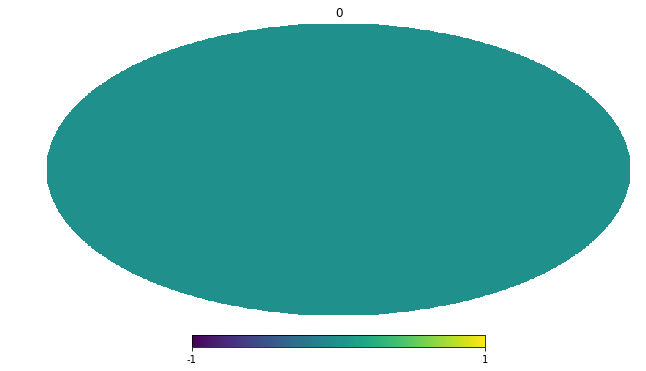

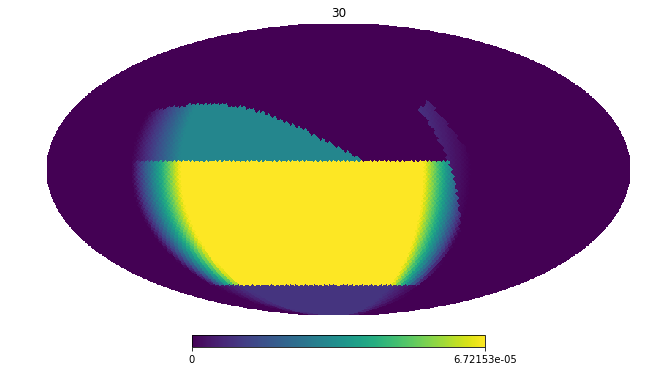

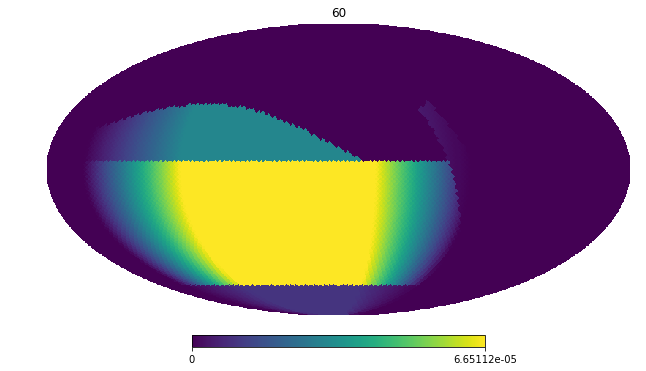

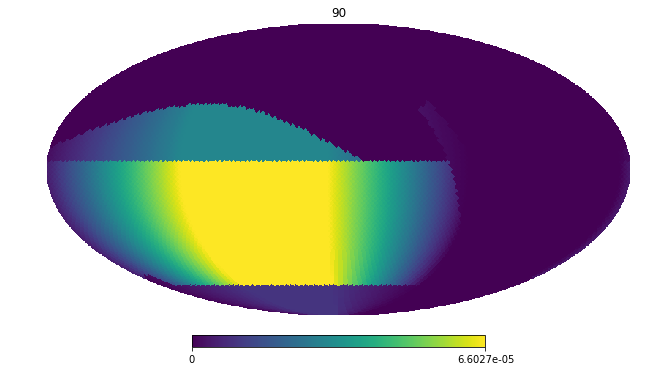

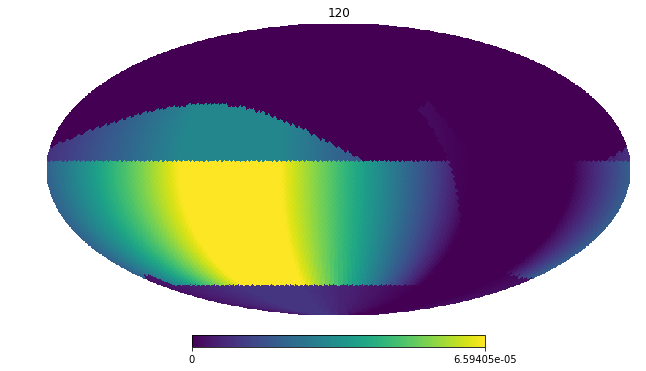

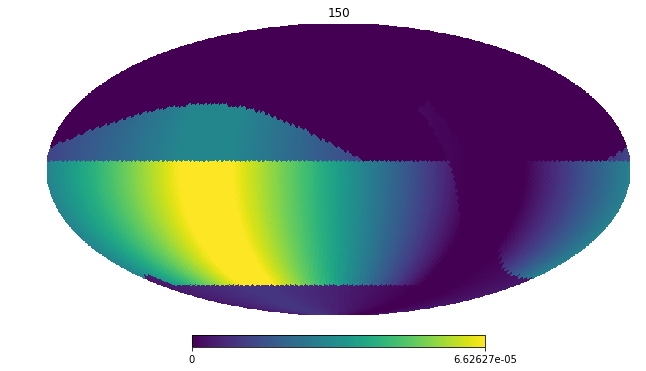

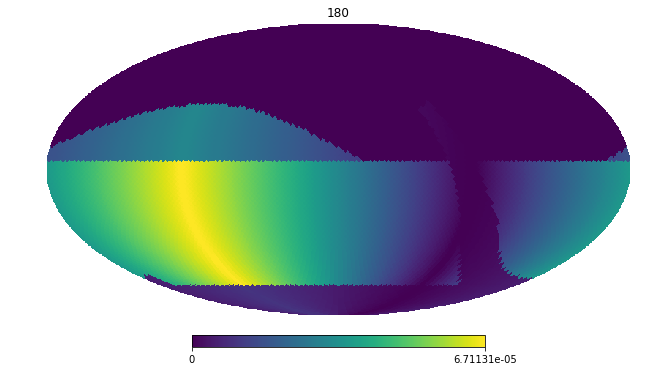

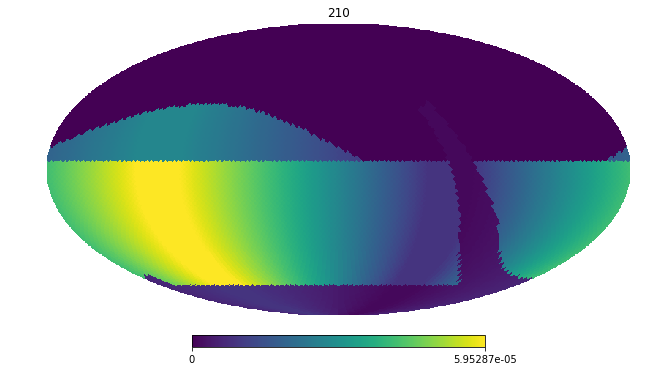

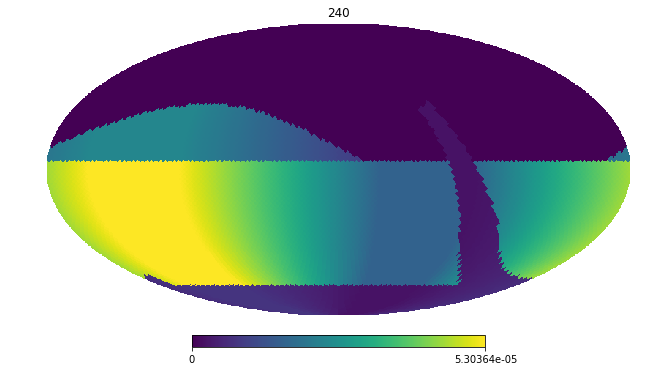

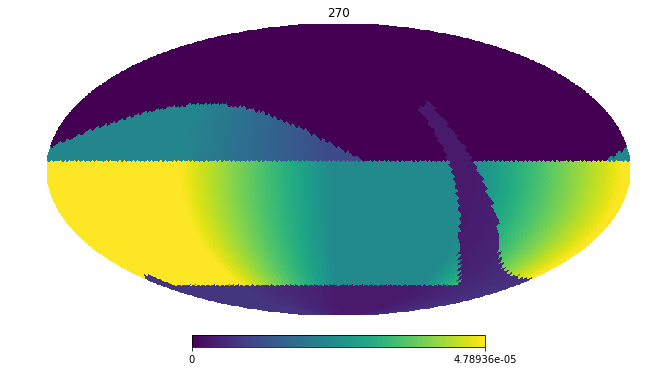

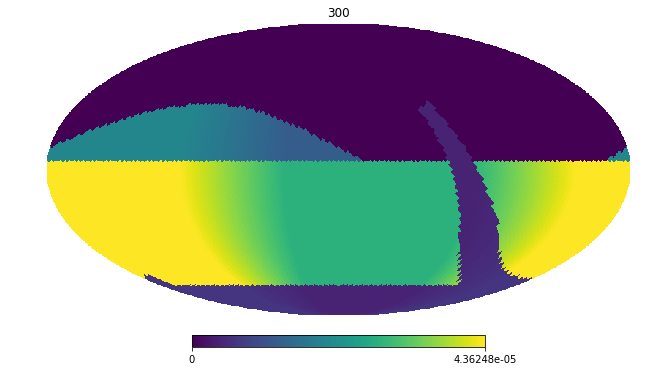

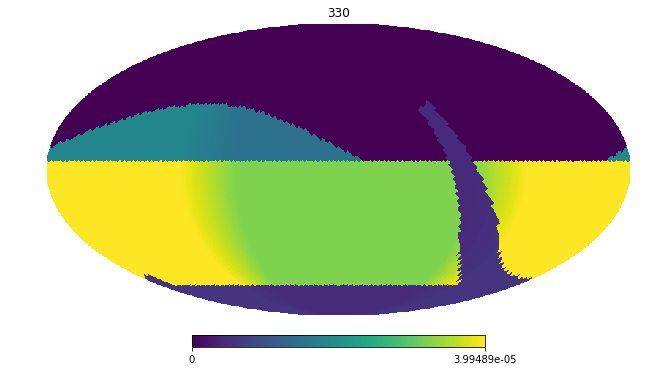

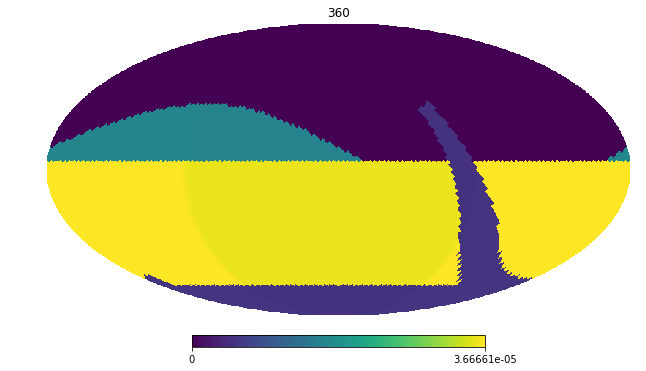

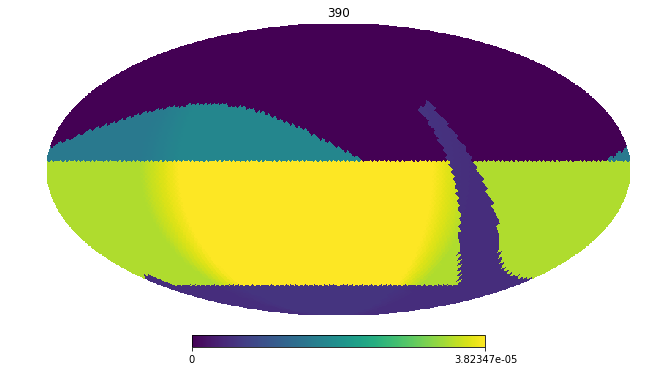

In [6]:
for night in np.arange(0,395, 30):
    temp = fp(mjd_start + night)['r']
    hp.mollview(temp, title=night)

In [7]:
# The call returns a normalized map. Needs to be scaled up by the number of healpix vists
# We can call that
ce = fp.estimate_counts(mjd_start+3652, nvisits=2e6)

In [8]:
# Note the output is a structured array with the columns labeled. That's a view because the internal array
# is just a single n_filt x n_healpix array. (I got some stack overflow points getting views explained to me)
ce

array([( 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ),
       ( 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ),
       ( 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ),
       ...,
       (30.98916399, 30.98916399, 30.98916399, 30.98916399, 30.98916399, 30.98916399),
       (30.98916399, 30.98916399, 30.98916399, 30.98916399, 30.98916399, 30.98916399),
       (30.98067962, 30.98067962, 30.98067962, 30.98067962, 30.98067962, 30.98067962)],
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('y', '<f8')])

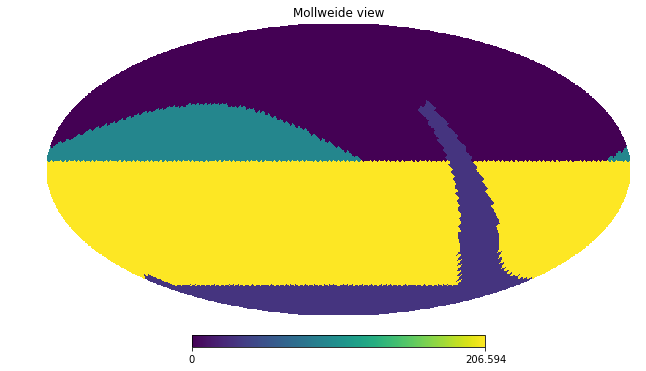

In [9]:
hp.mollview(ce['r'])

Text(0, 0.5, 'Number of healpixels')

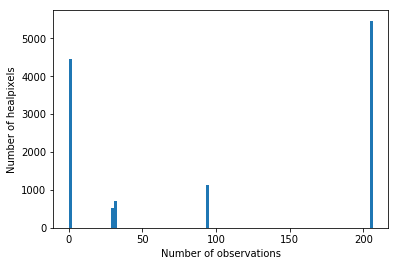

In [10]:
_ack = plt.hist(ce['r'], bins=100)
plt.xlabel('Number of observations')
plt.ylabel('Number of healpixels')

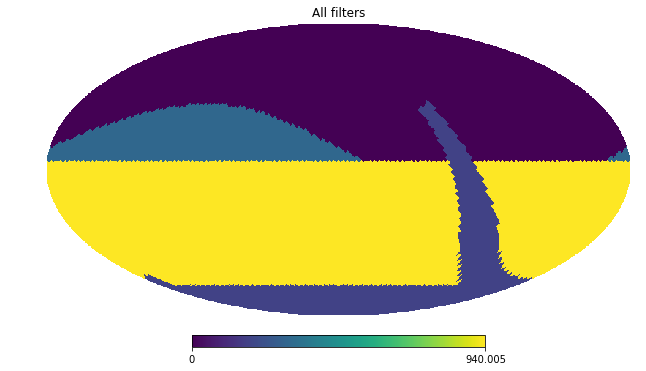

In [11]:
sum_map = 0
for key in ce.dtype.names: 
    sum_map += ce[key]
hp.mollview(sum_map, title='All filters')

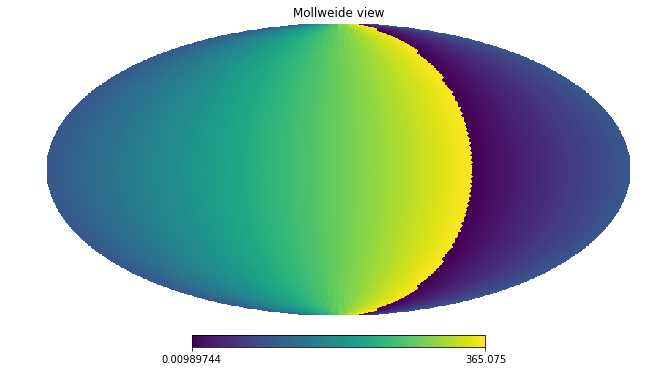

In [12]:
# on start up, the footprint computes the phase of every healpix
hp.mollview(fp.phase)

Text(0.5, 0, 'time')

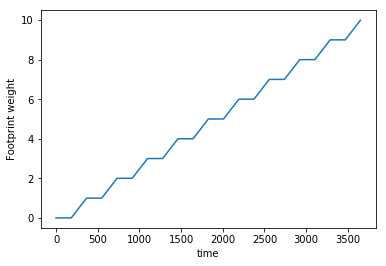

In [13]:
# Here's what's happening at a single healpixel. 
t = np.arange(0., 3652, 1)
step = step_line(t, 1., 365.25, phase=0)
plt.plot(t, step)
plt.ylabel('Footprint weight')
plt.xlabel('time')



Text(0.5, 0, 'time')

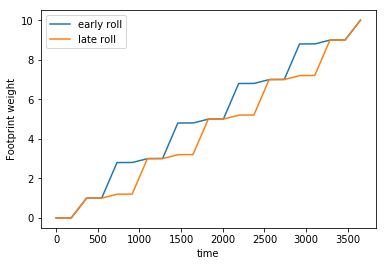

In [14]:
# So now we can set up a rolling with a different function
slopes_on = [0., 1., 1.8, 0.2, 1.8, 0.2, 1.8, 0.2, 1.8, 0.2, 1., 1.]
slopes_off = [0., 1.,  0.2, 1.8, 0.2, 1.8, 0.2, 1.8, 0.2, 1.8, 1., 1.]

ss = step_slopes(t, slopes_on, 365, phase=0)
plt.plot(t,ss, label='early roll')
ss = step_slopes(t, slopes_off, 365, phase=0)
plt.plot(t, ss, label='late roll')
plt.legend()
plt.ylabel('Footprint weight')
plt.xlabel('time')


In [15]:
# OK, let's make a few footprint objects and combine them together to do rolling
fp_non_wfd = Footprint(mjd_start, sun_RA_start=sun_RA_start)
fp_wfd_north = Footprint(mjd_start, sun_RA_start=sun_RA_start, step_size=slopes_on, step_func=step_slopes)
fp_wfd_south = Footprint(mjd_start, sun_RA_start=sun_RA_start, step_size=slopes_off, step_func=step_slopes)

In [16]:
# quick cheat on labeling WFD pix
wfd_indx = np.where(hp_footprints['r'] == 1)[0]
non_wfd_indx = np.where(hp_footprints['r'] != 1)[0]

# Since we have a continuous WFD, can just do this to split it in two. 
nslice = 2
wfd = hp_footprints['r'] * 0

wfd[wfd_indx] = 1
wfd_accum = np.cumsum(wfd)
split_wfd_indices = np.floor(np.max(wfd_accum)/nslice*(np.arange(nslice)+1)).astype(int)
split_wfd_indices = split_wfd_indices.tolist()
split_wfd_indices = [0] + split_wfd_indices



In [17]:
for key in hp_footprints:
    temp = hp_footprints[key] + 0
    temp[wfd_indx] = 0
    fp_non_wfd.set_footprint(key, temp)
    
    temp = hp_footprints[key] + 0
    temp[non_wfd_indx] = 0
    indx = wfd_indx[split_wfd_indices[0]:split_wfd_indices[1]]
    temp[indx] = 0
    fp_wfd_south.set_footprint(key, temp)
    
    temp = hp_footprints[key] + 0
    temp[non_wfd_indx] = 0
    indx = wfd_indx[split_wfd_indices[1]: split_wfd_indices[2]]
    temp[indx] = 0
    fp_wfd_north.set_footprint(key, temp)

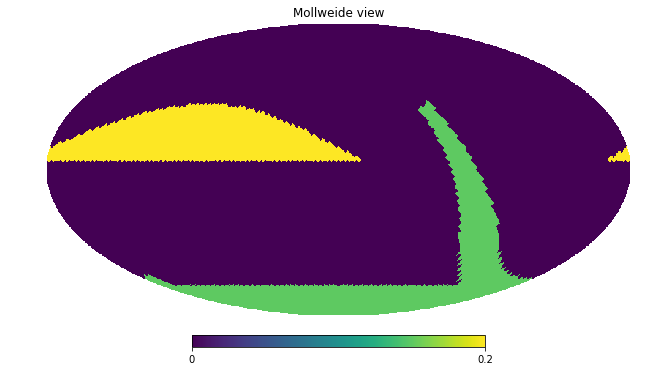

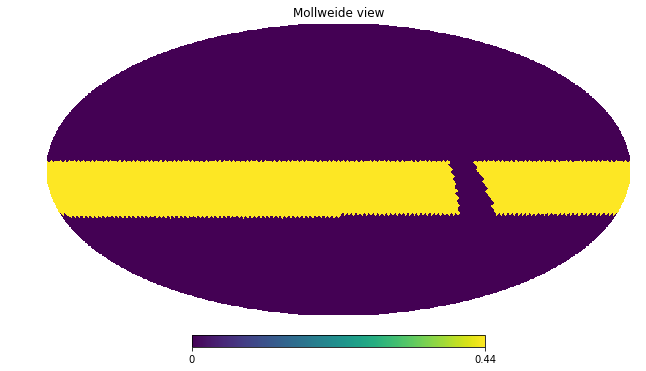

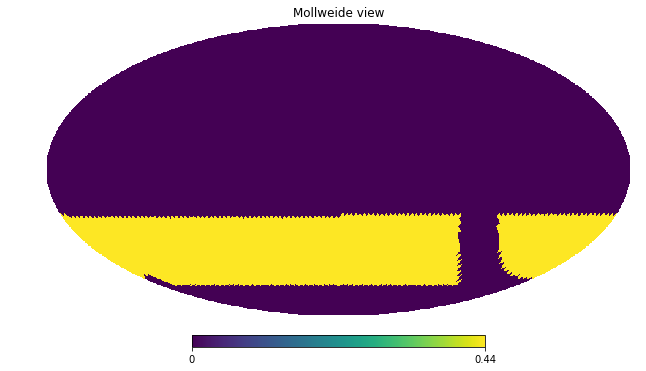

In [18]:
#now we have three regular footprint objects
hp.mollview(fp_non_wfd.footprints[1])
hp.mollview(fp_wfd_north.footprints[1])
hp.mollview(fp_wfd_south.footprints[1])


In [19]:
# So, now we have three footprints, each using a different function for how they should
# evolve with time. We can send a list to the Footprints class (a subclass of Footprint), and
# it will call each one, properly normalize the sum, and off we go
footprints_obj = Footprints([fp_non_wfd, fp_wfd_north, fp_wfd_south])

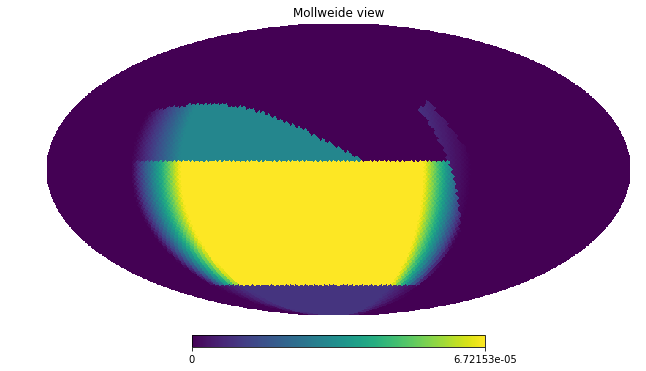

In [20]:
hp.mollview(footprints_obj(mjd_start+30)['r'])

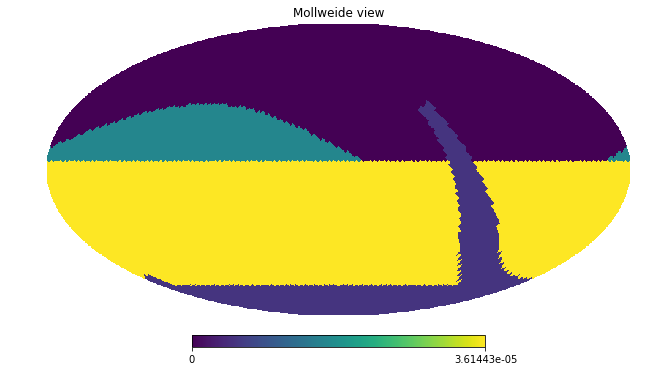

In [21]:
hp.mollview(footprints_obj(mjd_start+365*10)['r'])

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


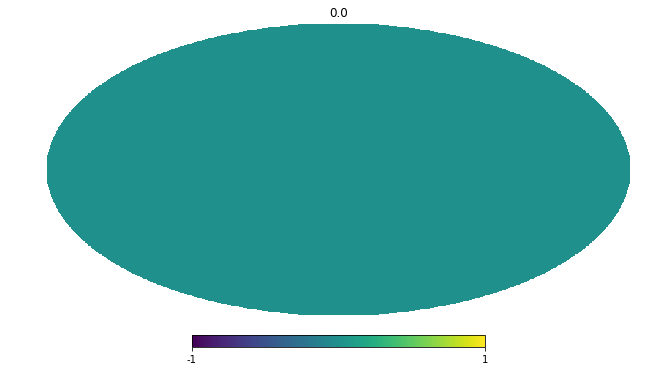

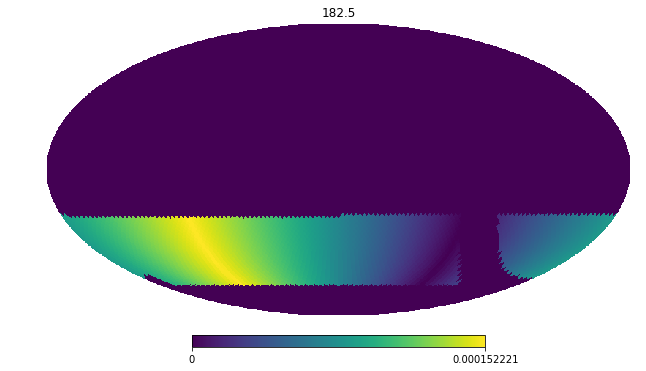

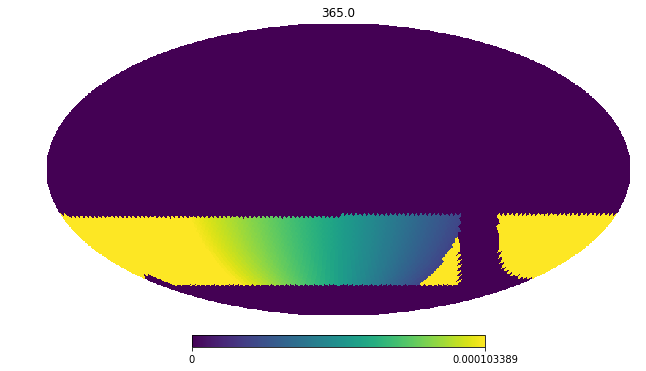

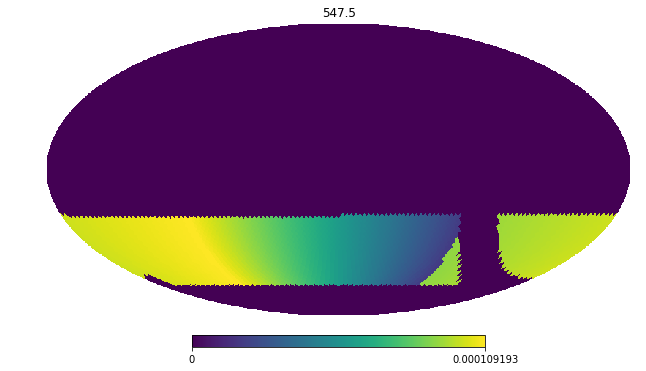

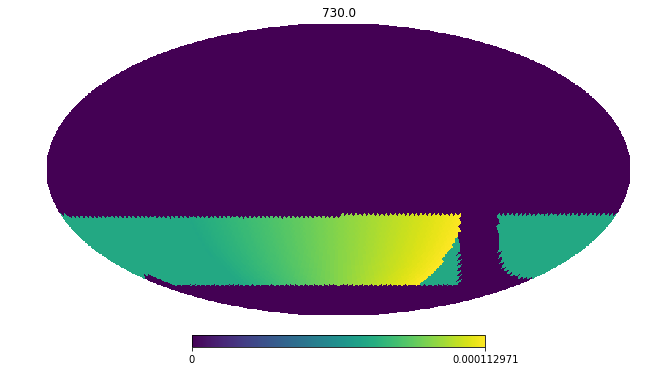

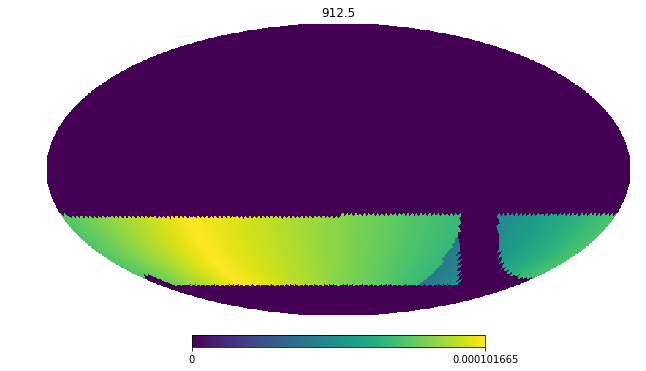

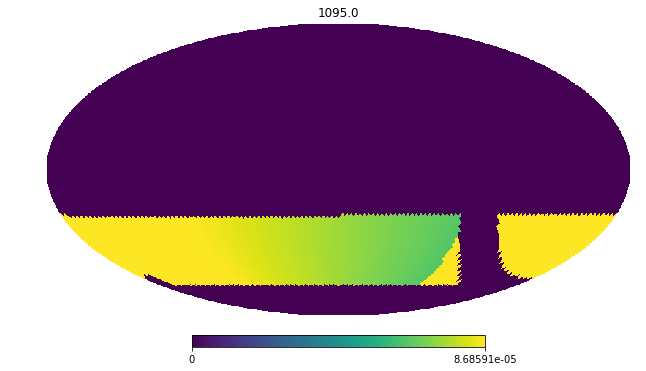

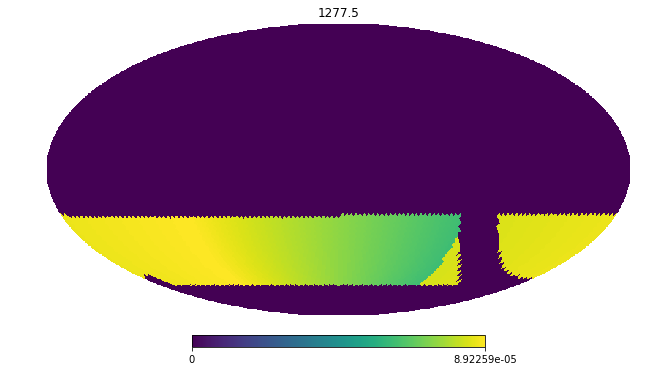

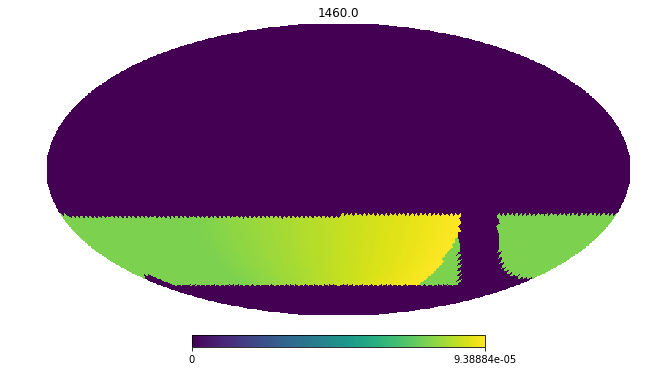

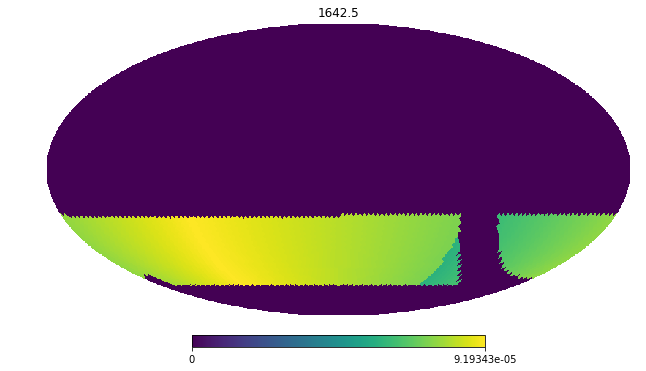

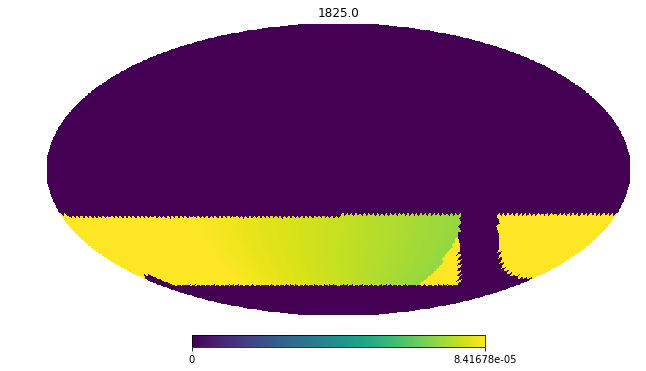

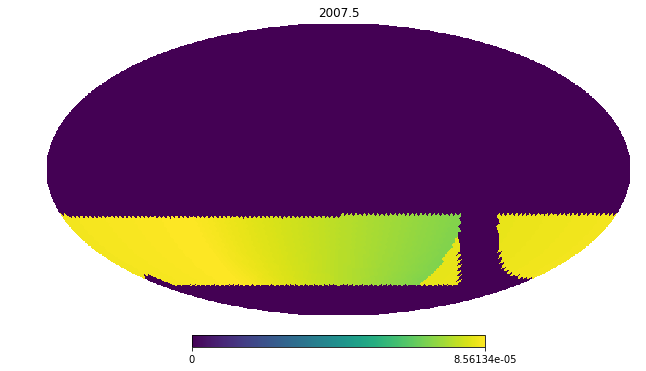

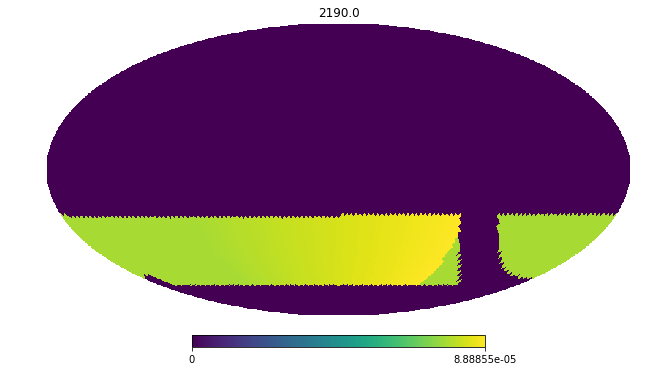

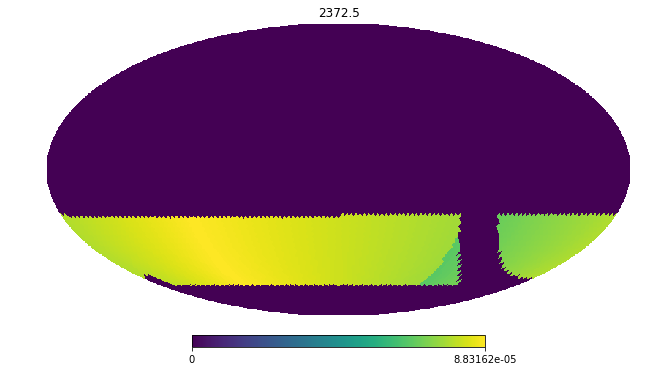

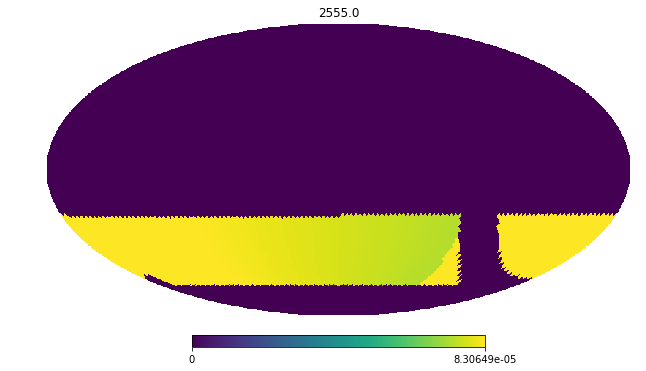

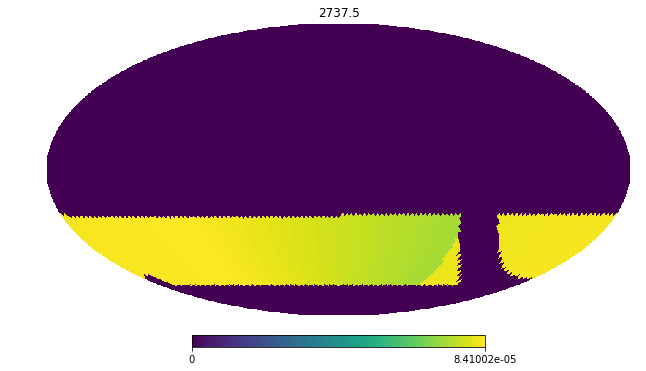

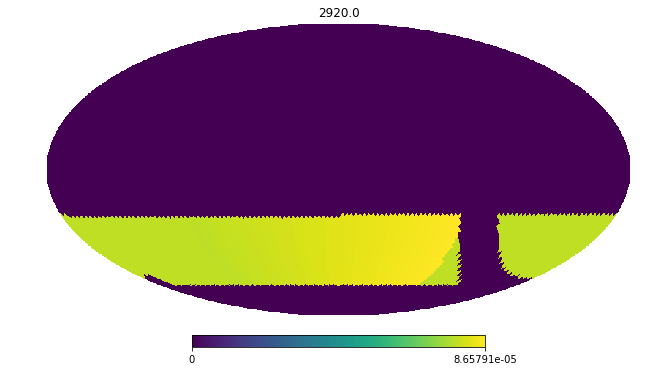

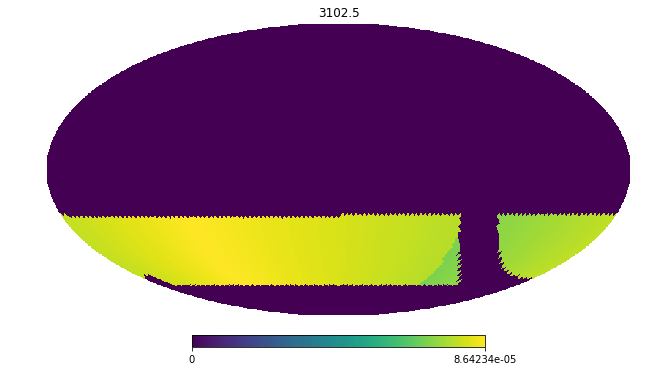

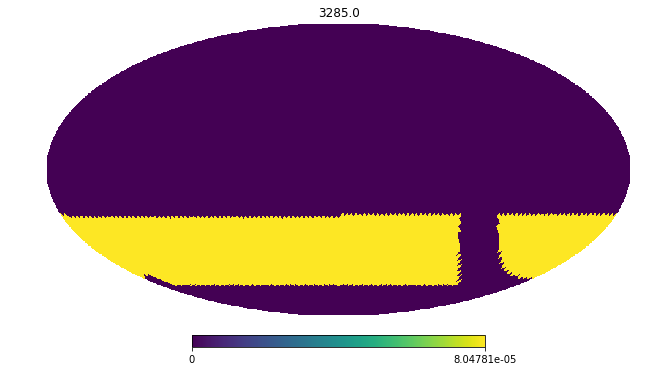

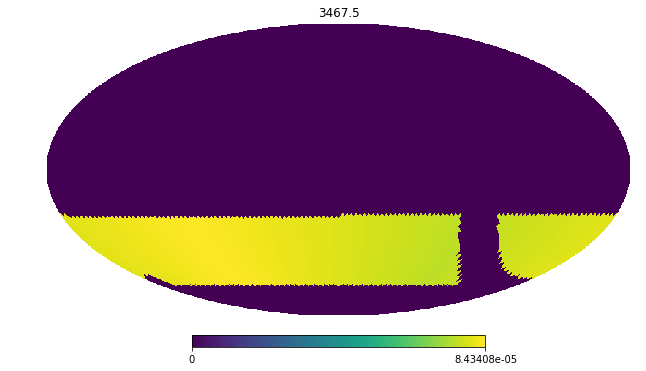

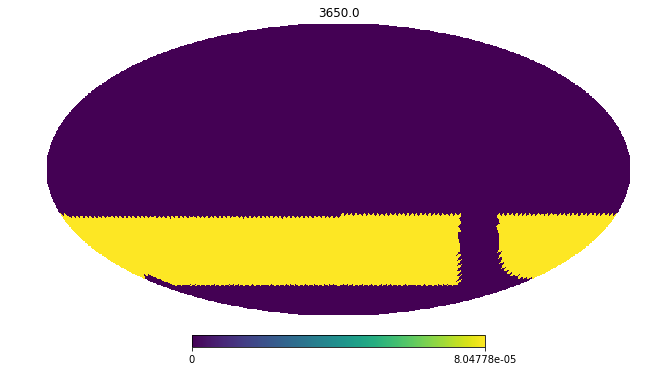

In [22]:
for night in np.arange(0,3652, 365/2):
    temp = fp_wfd_south(mjd_start + night)['r']
    hp.mollview(temp, title=night)

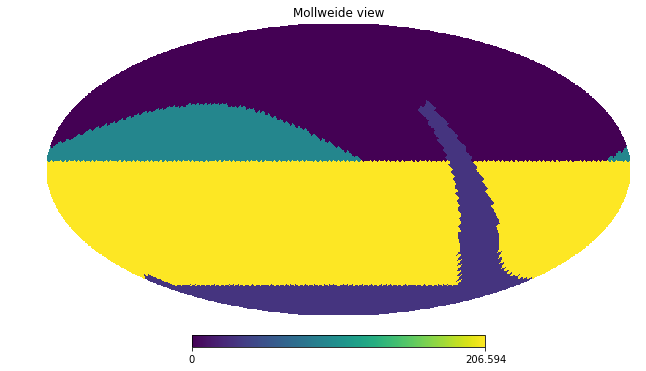

In [23]:
# can we still estimate counts? Looks like yes!
ce = footprints_obj.estimate_counts(mjd_start+3652, nvisits=2e6)
hp.mollview(ce['r'])